# UC San Diego: Neural Data Science
## Classifying Sleep Based on Prior Working Memory Task Load

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [ X ] NO - keep private

# Names

- Anjali Srinivasan
- Aaditya Prasad
- Joakim Nguyen
- Yohan Kim
- Kenton Guarian
- Mary Kovic

# Overview

In this project, we investigated whether it is possible to determine if an individual performed a high-load or low-load working memory task prior to sleep based on EEG data from their sleep. This analysis made use of the LISC database to determine what features of the EEG data would be the most applicable to working memory. After mining for relevant terms, we cleaned the data, extracted our features of interest, and performed k-means clustering. We then evaluated whether the clustering successfully separated the data by what working memory task the participant performed.

<a id='research_question'></a>
# Research Question

Can we predict whether a subject performed a high-load or low-load working memory task prior to sleeping based on EEG signals from that nap?

<a id='background'></a>

## Background & Prior Work

   After investigating the Nap EEG data, we became curious about whether we could use the scalp EEG signals to determine whether the participant performed a high-load or a low-load working memory task prior to sleeping. We knew from prior knowledge that sleep has a role in consolidating information and memories. Additionally, Ellenbogen et al (2006) demonstrated that sleep protects declarative memories and has a role in memory recall [1].
    
   Sleep deprivation can have an effect on cognitive function and performance - in Choo et al (2005), participants that were sleep deprived performed worse on the n-back working memory task than their rested counterparts [2]. Additionally, Gradisar et al (2016) observed that adolescents that are sleep deprived (less than 8 hours of sleep) or have a sufficient amount of sleep (greater than 9 hours) perform worse than adolescents with 8-9 hours of sleep on various working memory tasks [3]. The effect sleep has on working memory performance is clearly complex and nuanced.

   Looking at this data, it is clear that sleep can have a substantial effect on working memory task performance, and that the brain has a role in consolidating memories during sleep. Thus, we are curious about whether there is a significant difference in brain activity after performing a working memory task. Pugin et al (2015) found that after undergoing working memory training, participants had an increase of slow wave activity during sleep [4]. We are curious as to whether a difference exists in nap EEG recordings without training and are investigating whether the complexity of the working memory task has a noticeable effect on the nap EEG recordings.

References:
- 1) https://www.sciencedirect.com/science/article/pii/S0960982206016071
- 2) https://www.sciencedirect.com/science/article/pii/S1053811904007074?via%3Dihub
- 3) https://link.springer.com/article/10.1111/j.1479-8425.2008.00353.x
- 4) https://academic.oup.com/sleep/article/38/4/607/2416936

# Hypothesis


Our hypothesis is that there will be more activity in the brain during sleep after a high-load working memory task compared to a low-load working memory task. Thus, we predict that it is possible to accurately cluster the data by working memory task load.

# Dataset(s)

LISC
- Link to the dataset: https://lisc-tools.github.io/lisc/auto_tutorials/index.html
- Number of observations: all scientific literature
LISC is a tool that allows users to perform text mining on scientific articles and various analyses. Users can query databases for terms of interest and learn how many articles contain those terms.

Nap EEG
- Link to the dataset: https://osf.io/chav7/
- Number of observations: 64-channel continuously scalped EEG data for 19 participants over 36 datasets

To combine these datasets, we will be utilizing LISC to find important terms that co-occur between sleep and working memory. We will then attempt to use these terms to determine which features to extract from the data when performing clustering analysis.

In [ ]:
# first, let's import the necessary packages
!pip install numpy mne pandas matplotlib tqdm

In [ ]:
# making necessary directories
!mkdir original_eeg
!mkdir cleaned_eeg
!mkdir spindle_files
!mkdir lisc_analysis

In [1]:
# imports
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import copy
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from lisc import Counts
from lisc.utils.db import SCDB
from lisc.utils.io import save_object
from lisc.plts.counts import plot_matrix
from wordcloud import WordCloud, get_single_color_func

from data.lisc_db.terms.terminology import stages, waves, eeg_features_2, additional_features

from tqdm import tqdm
import mne

# Data Wrangling

Our first step is to retreive the EEG data. To do this, we will need to use the download links provided in the file 'available_subjects.csv' (provided in the current working directory) to retrieve the eeg data.

Note for available_subjects.csv:
This file was originally retreived from the github page for the original paper.
Link to github: https://github.com/nmningmei/Get_Sleep_data
However, there were multiple cells in this file that had typos and naming errors - we edited these errors manually. The 'available_subjects.csv' file provided with this project is the fixed version of the one from the original github.

The eeg data will be saved in the 'original_eeg' directory.

Samples with 'l2' in the name are recordings taken after a low-load working memory task. Samples with 'l5' in the name are recordings taken after a high-load working memory task.

In [ ]:
subjects_df = pd.read_csv('available_subjects.csv')

for link in subjects_df['link']:
    link = link.strip()
    !wget -P original_eeg/ {link}

# store all vhdr filenames to iterate through for cleaning
vhdrs = [name for name in subjects_df['name'] if name.endswith('.vhdr')]

Next, we are going to retreive the spindle annotation data. We will be using this data in exploratory analyses and will attempt to use these labels to classify the data.

The spindle annotation data will be saved in the 'spindle_files' directory.

In [ ]:
for file_name,link in zip(subjects_df['annotation_file_name'],subjects_df['annotation_file_link']):
    save_file_name = ".spindle_files/" + file_name
    !wget -O {save_file_name} {link}

# Data Cleaning

Next, we need to clean the eeg data.

While exploring the dataset, we noticed a discrepancy between the code provided in the github (link provided in the 'Data Wrangling' section) and the code provided in the original dataset (link provided in the dataset information section). The code provided in the original dataset filtered the data using a bandpass filter, ran it through a notch filter, and performed ICA (independent component analysis) on it.

In contrast, the code on the github did not run the samples through ICA. We weren't sure which to follow - if ICA was not necessary we did not want to run it, as it is a computationally intensive algorithm that takes some time to run,

To clarify whether we should run each sample through ica, we contacted Ning Mei, one of the authors on the paper published with the dataset. Mei informed us that ICA has little to no effect on the data from this dataset, so it is not worth the time to run it.

In [3]:
def raw_import(signal_str):
    
    # read in raw eeg file and set channel types
    raw = mne.io.read_raw_brainvision(signal_str)
    
    # Set channel type as said in original research paper
    channel_types = {'LOc':'eog','ROc':'eog','Aux1':'misc'}
    raw.set_channel_types(channel_types) # Set channel type as said in original research paper
    
    
    raw_ref ,_  = mne.set_eeg_reference(raw, ref_channels='average', projection=True,)
    raw_ref.apply_proj() # it might tell you it already has been re-referenced, but do it anyway

    # read standard montage - montage is important for visualization
    montage = mne.channels.make_standard_montage('standard_1020');#montage.plot()
    raw.set_montage(montage)
    
    # print some information about the data
    # print(raw.info)
    # The graph's voltage is microvolt, but actually it should be in volts, so we convert that
    scalingDict=dict(mag=1e-12, grad=4e-11, eeg=20e-6, eog=150e-6, ecg=5e-4, emg=1e-3, ref_meg=1e-12,
                     misc=1e-3, stim=1, resp=1, chpi=1e-4)
    
    # plot and reload the data
    raw.plot(start=0., duration = 10.0, n_channels=20, scalings = scalingDict)
    raw.load_data()
    
    return raw

In [ ]:
def filter_channels(raw):
    
    # create list of channels to retain in raw
    chan_list=raw.ch_names[:-2]# exclude 'AUX','STIM' channels
    if 'LOc' not in chan_list:
        chan_list.append('LOc')
    if 'ROc' not in chan_list:
        chan_list.append('ROc')
    
    # pick useful channels to use; which means to remove unnecessary channels like AUX
    raw.pick_channels(chan_list)
    raw.set_channel_types({'LOc':'eog','ROc':'eog'})
    raw.pick_channels(chan_list)
    
    # pick channels by type (eeg)
    picks = mne.pick_types(raw.info,meg=False,eeg=True,eog=False,stim=False) # Only use eeg
    
    # band-pass filter the data so that all signal fits between low frequency of 200 and
    # high frequency of 1
    raw.filter(l_freq=200, h_freq=1,l_trans_bandwidth=0.01, h_trans_bandwidth='auto', filter_length='auto',
               picks=picks)
    noise_cov = mne.compute_raw_covariance(raw.set_eeg_reference(), picks=picks)
    
    # apply notch filter(from 60 to 240, with interval of 60)
    raw.notch_filter(np.arange(60,241,60), picks=picks)
    return picks, noise_cov

In [ ]:
def save_cleaned_result(clean_raw, signal_str):

    # save cleaned eeg files as .fif into the cleaned_eeg directory
    save_dir = "./cleaned_eeg/"
    
    savename=signal_str[:len(signal_str)-5:] + '.fif'
    clean_raw.save(save_dir + savename, # file name
               buffer_size_sec=None, # size of data chunks in seconds. 
               proj=False, # always false
               overwrite = False, # Default to "false" so you don't mess up
    )

In [ ]:
# iterate through each eeg sample
for vhdr in vhdrs:
    signal_str = "./original_eeg/" + vhdr # Path to Signal
    
    # import raw data
    raw = raw_import(signal_str)
    
    # filter data
    picks, noise_cov = filter_channels(raw)
    
    # save cleaned data as a .fif file
    save_cleaned_result(raw, vhdr)

# Data Visualization

Now that our data is cleaned, let's take a look at it from before and after filtering. We'll use the file suj11_l2nap_day2 as our example.

Extracting parameters from original_eeg/suj11_l2nap_day2.vhdr...
Setting channel info structure...
Adding average EEG reference projection.
1 projection items deactivated
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_58797/849980224.py:4: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  raw = mne.io.read_raw_brainvision(signal_str)


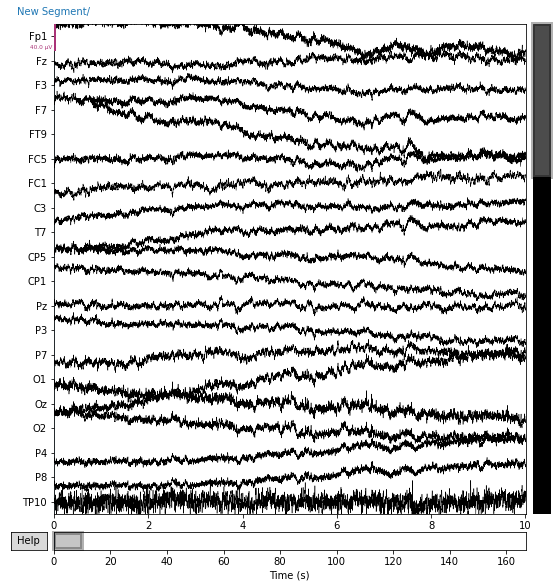

Reading 0 ... 166722  =      0.000 ...   166.722 secs...


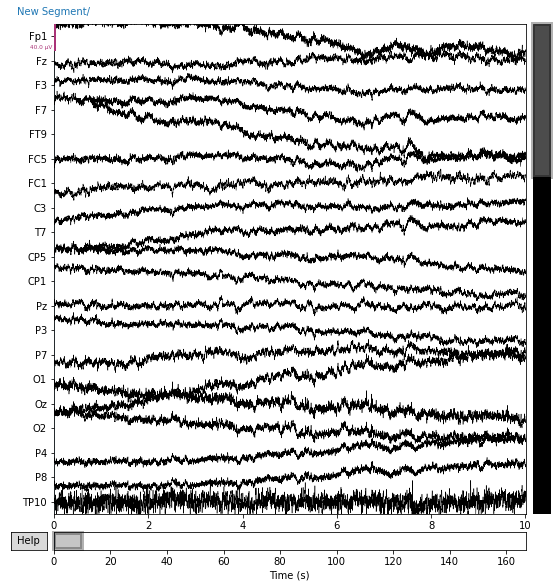

<RawBrainVision | suj11_l2nap_day2.eeg, 64 x 166723 (166.7 s), ~81.5 MB, data loaded>

In [6]:
# first, plot the prefiltered data and display basic information
raw = raw_import("original_eeg/suj11_l2nap_day2.vhdr")
raw.plot()
raw

In [ ]:
# now, let's look at the filtered data
clean_raw = mne.io.read_raw_fif("cleaned_eeg/suj11_l2nap_day2.fif")
clean_raw.plot()
clean_raw

As we can see, the filtering has removed much of the noise present in our data. Great! Now we're able to perform some analysis and extract relevant features from the data.

However, first, we must ask the question "What features do we extract?" To answer this, let's take a small break from the Nap EEG data and turn our attention towards LISC. When starting this project, we were unsure of what terms were related between sleep and working memory. Using LISC, we were able to narrow down possible terms to look at in our classification analysis.

In [ ]:
def run_and_save(counts, filename):
    counts.run_collection()
    main_dir = os.path.dirname(os.getcwd())
    db_dir = os.path.join(main_dir, 'data/', db.get_folder_path('counts'))
    save_object(counts, filename, directory=db_dir)

[TODO change this to save files to lisc_analysis directory]

In [ ]:
def load_counts(filename):
    main_dir = os.path.dirname(os.getcwd())
    data_rpath = db.get_file_path('counts', filename)
    data_abspath = os.path.join(main_dir, 'data/', data_rpath)
    return pd.read_pickle(data_abspath)

In [ ]:
def pick_top(counts, top_n:int=None, percentile:float=None):
    counts = copy.deepcopy(counts)
    len_A = len(counts.terms['A'].terms)
    len_B = len(counts.terms['B'].terms)

    top = []
    if top_n:
        percentile = 0
    for i in range(len_A):
        for j in range(len_B):
            if counts.score[i][j] > counts.score.max() * percentile:
                top.append([counts.terms['A'].terms[i][0], counts.terms['B'].terms[j][0], counts.score[i][j]])

    top = sorted(top, key=lambda x: x[2], reverse=True)
    if top_n:
        top = top[:top_n]
    return top

In [ ]:
# initialize lisc SCDB (database) object.
db = SCDB('lisc_db')
db.gen_paths()

First, let's look more closely at terms associated with working memory in literature. To do this, we will be making use of terms from the Cognitive Atlas - https://www.cognitiveatlas.org/

In [ ]:
url = "https://www.cognitiveatlas.org/concepts/categories/all"
page = requests.get(url)
data = page.text
soup = BeautifulSoup(data, 'html.parser')

# Let's cut down html into the categories of concepts
page_content = soup.find('div', id='pagecontent')
categories = page_content.find_all('h3')
categories = list(enumerate([category.get_text() for category in categories]))
categories

In [ ]:
# Select which category by index
category_idx = 5

# Obtain all the concept terms in the category you chose
category = soup.find(string=categories[category_idx][1]).parent
concepts = category.find_next_sibling('div').find_all('a')
concepts = [term.get_text() for term in concepts]

# Remove some words that aren't productive in "concepts".
remove = ['memory', 'skill', 'learning', 'knowledge']
concepts = [concept for concept in concepts if concept not in remove]

In [ ]:
# Run co-occurances of "working memory" to the concepts
terms_a = ["working memory"]
terms_b = sorted(concepts) # alphabetical order

counts = Counts()
counts.add_terms(terms_a, dim='A')
counts.add_terms(terms_b, dim='B')

In [ ]:
# Save the Counts data
run_and_save(counts, 'wm-memlrn.p')

In [ ]:
# Load the counts data and compute its scores
pickle1 = load_counts('wm-memlrn.p')
pickle1.compute_score('normalize', dim='A')

# Prepare a wordcloud
                            
# LISC's wordcloud function won't suffice so we'll do it ourselves.
###################################################################

# Compile the words and frequencies into a dictionary to pass into the WordCloud object.
# Conveniently, our data is already 1D.
Dict = {}
for word, score in zip(pickle1.terms['B'].terms, pickle1.score[0]):
    Dict[word[0]] = score
# Tweak the parameters to produce a beautiful wordcloud.
wc = WordCloud(width=2560, height=1440, background_color='white').fit_words(Dict)
color_func1 = get_single_color_func('deepskyblue')

In [ ]:
plot_matrix(pickle1, attribute='score', cmap='blue', figsize=(30, 5), square=True) # kwargs sent to seaborn

In [ ]:
plt.figure(figsize=(18,10))
plt.imshow(wc.recolor(color_func=color_func1), interpolation='bilinear')
plt.axis('off')

Now that we know what terms appear most frequently in working memory literature, let's investigate what terms co-occur between 'learning and memory' and 'EEG features'.

In [ ]:
# Prepare Counts object
terms_c = sorted(concepts)
terms_d = sorted([wave + ' ' + feature for wave in waves for feature in eeg_features_2] + additional_features)
terms_d.remove('slow wave')

counts2 = Counts()
counts2.add_terms(terms_c, dim='A')
counts2.add_terms(terms_d, dim='B')

In [ ]:
run_and_save(counts2, 'memlrn-eeg.p')

In [ ]:
# Load the counts data and compute its scores
pickle2 = load_counts('memlrn-eeg.p')
pickle2.compute_score('normalize', dim='A')
plot_matrix(pickle2, attribute='score', transpose=True, figsize=(30, 15), square=True)

This matrix is really big and generally unreadable. Let's narrow down our search a bit and find co-occurences between 'working memory' exclusively and 'EEG features'.

In [ ]:
top_terms = pick_top(pickle1, top_n=12)
pd.DataFrame(top_terms)

# Ignore this part underneath
Dict = {}
for word, score in zip(pickle1.terms['B'].terms, pickle1.score[0]):
    Dict[word[0]] = score
wc = WordCloud(width=2560, height=1440, max_words=12, background_color='white').fit_words(Dict)
color_func1 = get_single_color_func('deepskyblue')

In [ ]:
plt.figure(figsize=(18,10))
plt.imshow(wc.recolor(color_func=color_func1), interpolation='bilinear')
plt.axis('off')

In [ ]:
# Prepare Counts object
terms_e = list(zip(*pick_top(pickle1, top_n=12)))[1]
terms_f = sorted([wave + ' ' + feature for wave in waves for feature in eeg_features_2] + additional_features)
terms_f.remove('slow wave')

counts3 = Counts()
counts3.add_terms(terms_e, dim='A')
counts3.add_terms(terms_f, dim='B')

In [ ]:
run_and_save(counts3, "wm-eeg.p")

In [ ]:
# Load the counts data and compute its scores
pickle3 = load_counts('wm-eeg.p')
pickle3.compute_score('normalize', dim='A')
plot_matrix(pickle3, attribute='score', cmap='purple', figsize=(30, 8), square=True)

As we can see, many of these working memory terms have co-occurences with different types of oscillations and waves. In sleep, each of these types of waves corresponds to a frequency range of scalp recordings. Seeing as how working memory seems to have a lot to do with different wavelengths and frequencies of brain activity, it is clear that extracting frequency data from each sample is a promising method to classifying our data.

To do this, we'll need to determine the power spectrum of the data. This will give us distribution of the signal power over frequencies, which will demonstrate which frequencies were most represented in the EEG data.

Let's look at the power spectrum for the data we visualized earlier:

In [ ]:
clean_raw.plot_psd(fmax=59)

 TODO [insert info about plot here]

# Data Analysis & Results

Now that we know what we're looking for, let's extract the power spectrum from each datapoint. We'll be using 'available_subjects.csv' to iterate through the data.

In [ ]:
def import_data(eeg_file, crop=True):
    
    # read in cleaned eeg file and crop it to a maximum of 30 minutes
    raw = mne.io.read_raw_fif(eeg_file, preload=True)
    
    # if crop is true, crop data to 1800 seconds
    if crop:
        raw.crop(tmax=1800)
    
    return raw

In [8]:
def epoch_data(data, spindle_file):
    
    events = pd.read_csv(spindle_file)
    annotation_events = events[events['Annotation'] == 'spindle']
    event_array = np.vstack([annotation_events['Onset'].values, [0] * annotation_events.shape[0],
                             [1] * annotation_events.shape[0]]).T.astype(int)
    
    epochs = mne.Epochs(raw, events = event_array, event_id = {'spindle':1}, tmin = -0.5, 
                        tmax = 1.5, baseline = (-0.5,-0.2), preload = True, picks = picks, detrend = 1)
    
    return epochs

In [ ]:
def extract_power_series(data):
    
    # run psd_welch on each dataset
    # note: dimensions of returned matrix change depending on whether psd_welch is run on epoched data
    pxx, fx = mne.time_frequency.psd_welch(data, fmin= 1., fmax = 50, n_fft=1000, n_overlap = 500)
    
    return pxx, fx

In [ ]:
eegs = np.array(subjects_df[subjects_df['name'].str.endswith('.eeg')]['name'])
eeg_file_names = [eegs[i].split('.')[0] + '.fif' for i in range(len(eegs))]
spindle_annotation_file_names = np.unique(np.array(subjects_df['annotation_file_name']))

In [ ]:
eeg_file_dir = "./cleaned_eeg/"
annotation_file_dir = "./spindle_files/"
skip = ["suj27_l5nap_day1.fif"]

First, let's try extracting features from the data at spindle locations.

In [ ]:
raw_power_series = []
flat_power_series = []
fxs = []
labels = []

for eeg_file_name, spindle_annotation_file_name in zip(eeg_file_names, spindle_annotation_file_names):
    
    # skip files in 'skip' directory - eeg signal is abnormal and should not be counted
    if eeg_file_name in skip:
        continue
        
    if 'l2' in eeg_file_name:
        # annotate with '0' if low-load
        labels.append(0)
    else:
        # annotate with '1' if low-load
        labels.append(1)
    
    full_eeg_path = eeg_file_dir + eeg_file_name
    full_spindle_annotation_path = annotation_file_dir + spindle_annotation_file_name
    
    # extract features from data epoched by spindle and epoch data by spindles
    raw = import_data(full_eeg_path), crop=False)
    epochs = epoch_data(raw, full_spindle_annotation_path)
    
    # extract power series
    psds, fx = extract_power_series(cropped_data)
    raw_power_series.append(psds)
    #power_series.append(np.mean(pxx,axis=0))
    #epoch_nums.append(pxx.shape([0]))
    fxs.append(fx)
    flat = psds.flatten()
    flat_power_series.append(flat)
    

#power_series = np.stack(power_series)
#fxs = np.stack(fxs)
raw_power_series = np.array(raw_power_series)
flat_power_series = np.array(flat_power_series)
fxs = np.array(fxs)
labels = np.array(labels)
print(power_series.shape)
print(fxs.shape)
print(labels.shape)
#epoch_nums = np.array(epoch_nums)
#print(epoch_nums.shape)
np.savez_compressed('extracted_features.npz',raw_psd=raw_power_series, flat_psd=flat_power_series, freqs=fxs,label=labels)
#np.savez_compressed('epoch_counts.npz',epoch_counts=epoch_nums,label=labels)

# Conclusion & Discussion

* Discussion of your results and how they address your experimental question(s).
* Discussed limitations of your analyses.
* You can also discuss future directions you'd like to pursue.